Import necessary libraries and set random seeds for reproducibility

In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
from engine import Value
from neuralnet import Neuron, Layer, MLP

np.random.seed(1337)
random.seed(1337)

Generate the dataset using the make_moons function from the sklearn library

[[ 1.12211461e+00  8.14771734e-02]
 [-8.18829413e-01  5.87900639e-02]
 [ 1.61370966e+00 -1.24645900e-01]
 [-9.23009184e-01  3.65228899e-01]
 [ 1.43851462e-01  4.43800492e-02]
 [ 1.64472466e-01  1.17383457e-01]
 [ 1.33877062e+00 -2.38009933e-01]
 [ 8.71148615e-01 -4.22717587e-01]
 [ 1.83129946e+00 -1.41043828e-01]
 [ 4.87571202e-01  6.39092830e-01]
 [ 3.74623511e-02  4.23588090e-01]
 [-4.43916853e-01  8.96739312e-01]
 [-8.12229494e-01  9.12090924e-01]
 [ 1.63552312e+00 -3.49996760e-01]
 [ 4.73539037e-01  9.57342599e-01]
 [ 7.53549316e-01  6.23727143e-01]
 [ 2.64212818e-01 -2.42419828e-01]
 [ 1.42755726e+00 -3.72510358e-01]
 [-3.72356057e-01  9.56691710e-01]
 [-9.61301967e-01  3.26090112e-01]
 [ 7.80858468e-01  7.97489402e-01]
 [ 9.16609029e-01 -4.27638438e-01]
 [ 1.04703809e+00 -5.44492470e-01]
 [-6.03630542e-02  1.19609088e-01]
 [ 2.91895380e-02  3.06838997e-01]
 [-3.95732255e-01  8.96543895e-01]
 [-1.04645910e-01  1.11788313e+00]
 [ 1.88110004e+00  2.99202568e-01]
 [ 8.27408779e-01  3

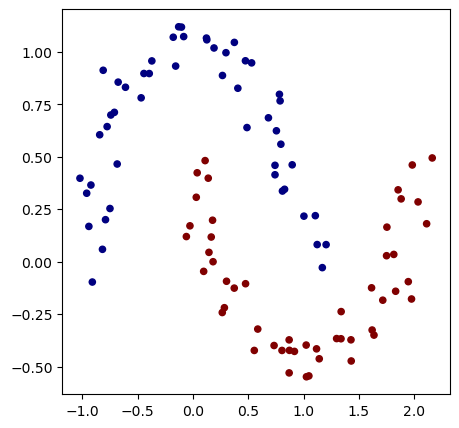

In [16]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

# Convert the labels to be either -1 or 1
y = y*2 - 1

# Visualize data in corresponding numbers and arrays
print(X)
print(y)

# Visualize the dataset in a 2D scatter plot
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

Initialize a 2-layer neural network with 16 neurons in each hidden layer and define the loss function

In [17]:
model = MLP(2, [16, 16, 1])
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


Data loss: Data loss is the primary part of the loss function that measures the performance of the model on the given dataset. Done by penalizing the model if the margin between the scores is not large enough.

Regularization loss: Regularization loss is an additional term in the loss function that helps prevent overfitting by discouraging overly complex models.The model learns to strike a balance between fitting the data well and maintaining simplicity.

In [18]:
# Define the loss function
def loss(batch_size=None):
    
    # DataLoader: Randomly sample a batch of data if batch_size is specified
    if batch_size is None:
        Xb, yb = X, y # If batch_size is not specified, use the entire dataset
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size] # Randomly sample a batch of data
        Xb, yb = X[ri], y[ri] # Xb and yb are the randomly sampled data
    inputs = [list(map(Value, xrow)) for xrow in Xb] # Convert the data to a list of lists of Value objects
    
    # Forward the model to get scores
    scores = list(map(model, inputs)) # scores is a list of scores mapped by the model
    
    # SVM "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)] # Compute the loss for each data point
    data_loss = sum(losses) * (1.0 / len(losses)) # Compute the average loss
    
    # (L2 regularization) Combine the data loss and regularization loss to get the total loss 
    alpha = 1e-4 # Regularization strength
    reg_loss = alpha * sum((p*p for p in model.parameters())) # Compute the regularization loss
    total_loss = data_loss + reg_loss # Compute the total loss
    
    # Compute accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)] # Compute the accuracy for each data point
    return total_loss, sum(accuracy) / len(accuracy) # Return the total loss and the average accuracy

Perform optimization using Stochastic Gradient Descent (SGD) for 100 steps


In [19]:
for k in range(100):
    # Forward propagate to compute the loss and accuracy
    total_loss, acc = loss()
    
    # Backward propagate to compute gradients
    model.zero_grad() # set all gradients to zero
    total_loss.backward() # backpropagate to compute gradients
    
    # Update the model parameters using SGD with a learning rate that decays over time
    learning_rate = 1.0 - 0.9*k/100 # learning rate decays over time
    for p in model.parameters(): # update the parameters
        p.data -= learning_rate * p.grad # update the parameters using SGD
    
    # Print the loss and accuracy after each step
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%") # Print the loss and accuracy


step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.723590533697202, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584202, accuracy 82.0%
step 4 loss 0.3692793385976538, accuracy 84.0%
step 5 loss 0.31354548191852194, accuracy 86.0%
step 6 loss 0.28142343497724337, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.2704862551637922, accuracy 91.0%
step 10 loss 0.24507023853658041, accuracy 91.0%
step 11 loss 0.25099055297915024, accuracy 92.0%
step 12 loss 0.21560951851922952, accuracy 91.0%
step 13 loss 0.2309037844640272, accuracy 93.0%
step 14 loss 0.2015215122789945, accuracy 92.0%
step 15 loss 0.22574506279282208, accuracy 93.0%
step 16 loss 0.19447987596204117, accuracy 92.0%
step 17 loss 0.21089496199246352, accuracy 93.0%
step 18 loss 0.15983077356303607, accuracy 94.0%
step 19 loss 0.1845374874688391, accuracy 93.0%
step 20 loss 0.18977522856087647, accurac

Visualize the decision boundary by creating a mesh grid and evaluating the model on the grid points

In [20]:
h = 0.25 # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # get the min and max of the first column
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # get the min and max of the second column
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), # create a meshgrid
                     np.arange(y_min, y_max, h)) 
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh] 
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores]) # convert the scores to a numpy array
Z = Z.reshape(xx.shape) # reshape the array to the shape of the meshgrid

(-1.548639298268643, 1.951360701731357)

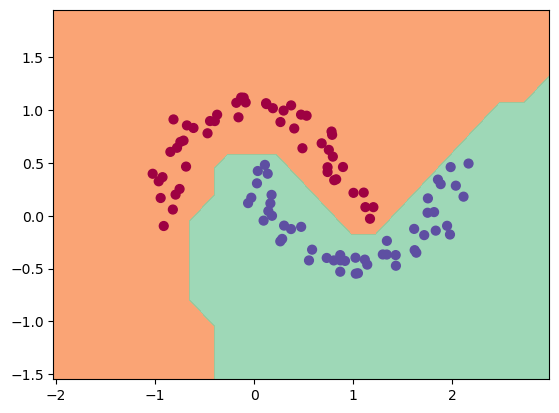

In [21]:
# Plot the decision boundary along with the original dataset

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())